In [1]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os


print(f"Tensorflow: {tf.__version__}")
print(f"Keras:      {tensorflow.keras.__version__}")
print(f"Numpy:      {np.__version__}")

Tensorflow: 2.6.0
Keras:      2.6.0
Numpy:      1.21.2


In [2]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 962A-4F22

 Directory of C:\Users\xjaal\Desktop\Modular\model

10/30/2021  03:02 PM    <DIR>          .
10/30/2021  03:02 PM    <DIR>          ..
10/17/2021  11:46 AM    <DIR>          .ipynb_checkpoints
10/30/2021  02:54 PM    <DIR>          cache
10/30/2021  03:02 PM    <DIR>          check
10/30/2021  03:02 PM           840,681 Clasificador.ipynb
10/29/2021  05:01 PM    <DIR>          data
10/30/2021  03:02 PM    <DIR>          hierarchical
10/30/2021  12:14 PM             3,431 model.py
10/30/2021  02:17 PM             4,018 prueba.py
10/29/2021  09:14 PM    <DIR>          test
10/30/2021  12:14 PM    <DIR>          __pycache__
               3 File(s)        848,130 bytes
               9 Dir(s)  343,395,049,472 bytes free


In [3]:
!dir data

 Volume in drive C has no label.
 Volume Serial Number is 962A-4F22

 Directory of C:\Users\xjaal\Desktop\Modular\model\data

10/29/2021  05:01 PM    <DIR>          .
10/29/2021  05:01 PM    <DIR>          ..
10/30/2021  03:26 PM    <DIR>          Landscape
10/30/2021  02:53 PM    <DIR>          People
               0 File(s)              0 bytes
               4 Dir(s)  343,390,552,064 bytes free


In [ ]:
import os

# ESTE NO COMPADRE
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3696 files belonging to 2 classes.
Using 2957 files for training.
Found 3696 files belonging to 2 classes.
Using 739 files for validation.


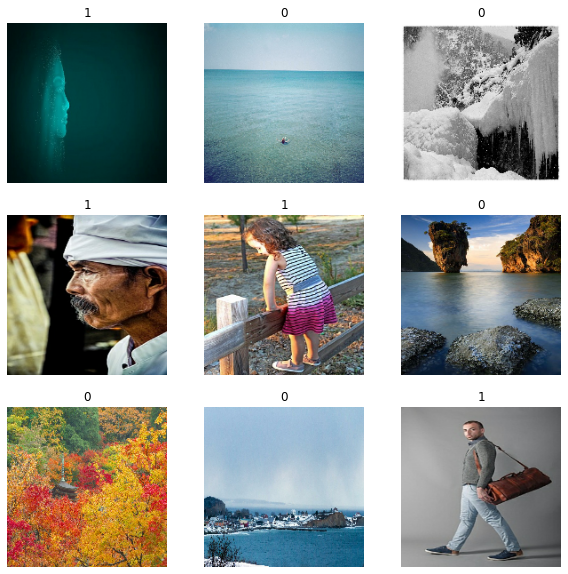

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

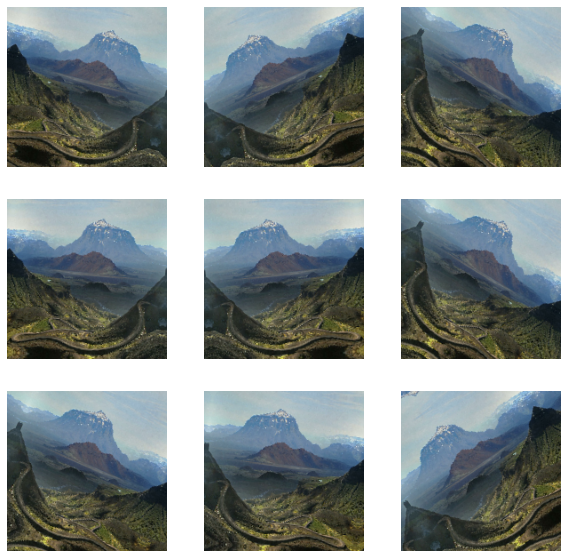

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



model = make_model(input_shape=image_size + (3,), num_classes=2)
#model.load_weights("check/save_at_25.h5")
#keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 25

callbacks = [
  keras.callbacks.ModelCheckpoint("check/save_at_{epoch}.h5"),
]

# checkPoint = keras.callbacks.ModelCheckPoint("besto.h5", verbose=1, save_best_only=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,)

Epoch 1/25
93/93 [==============================] - 26s 211ms/step - loss: 0.3471 - accuracy: 0.8569 - val_loss: 0.7295 - val_accuracy: 0.5196
Epoch 2/25


C:\Users\xjaal\miniconda3\envs\GVI\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


93/93 [==============================] - 18s 192ms/step - loss: 0.2297 - accuracy: 0.9185 - val_loss: 0.8683 - val_accuracy: 0.5196
Epoch 3/25
93/93 [==============================] - 18s 193ms/step - loss: 0.2071 - accuracy: 0.9263 - val_loss: 1.1443 - val_accuracy: 0.5196
Epoch 4/25
93/93 [==============================] - 18s 194ms/step - loss: 0.1756 - accuracy: 0.9371 - val_loss: 0.9520 - val_accuracy: 0.5196
Epoch 5/25
93/93 [==============================] - 18s 195ms/step - loss: 0.1729 - accuracy: 0.9330 - val_loss: 0.7632 - val_accuracy: 0.5670
Epoch 6/25
93/93 [==============================] - 18s 196ms/step - loss: 0.1710 - accuracy: 0.9391 - val_loss: 0.4052 - val_accuracy: 0.7889
Epoch 7/25
93/93 [==============================] - 19s 197ms/step - loss: 0.1638 - accuracy: 0.9422 - val_loss: 0.1923 - val_accuracy: 0.9310
Epoch 8/25
93/93 [==============================] - 19s 197ms/step - loss: 0.1501 - accuracy: 0.9449 - val_loss: 0.1521 - val_accuracy: 0.9621
Epoch 9/25

In [ ]:
img = keras.preprocessing.image.load_img(
    "C:/Users/xjaal/Pictures/dataset/class/buildings/110000.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
# Model1 = "This image is %.2f percent cat and %.2f percent dog."
# Model2 = 
# Model3 = 
print(
    "This image is %.2f percent P and %.2f percent L."
    % (100 * (1 - score), 100 * score)
)
print(predictions)

In [ ]:
for i in os.listdir("dataset/food-plant/"):
    img = keras.preprocessing.image.load_img(
    f"dataset/food-plant/{i}", target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    score = predictions[0]
    print(
        f"This image {i} is %.2f percent F and %.2f percent P."
        % (100 * (1 - score), 100 * score)
    )